## ===================================

In [1]:
import torch
import torch.nn as nn

from torchvision.models.vgg import vgg16

c:\prj\team3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(2022)
torch.cuda.manual_seed(2022)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = vgg16(pretrained=True)

# print(model)

fc = nn.Sequential(
    nn.Linear(25088,4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096,4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096,2)
)

model.classifier = fc
model.to(device)

c:\prj\team3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\prj\team3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
import tqdm
import os

from torchvision import datasets, models, transforms
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, Normalize
from torch.utils.data.dataloader import DataLoader
# from torch.optim.adam import Adam

import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import time

In [5]:
transforms_train = transforms.Compose([
    Resize(224),
    # RandomCrop((224,224),padding=4),
    # RandomHorizontalFlip(p=0.5),
    ToTensor(),
    Normalize(mean=(0.4914,0.4822,0.4465) , std = (0.247,0.243,0.261))
])

transforms_test = transforms.Compose([
    Resize(224),
    # RandomCrop((224,224),padding=4),
    # RandomHorizontalFlip(p=0.5),
    ToTensor(),
    Normalize(mean=(0.4914,0.4822,0.4465) , std = (0.247,0.243,0.261))
])

data_dir = './custom_dataset'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

lr = 0.00001
optim = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()

학습 데이터셋 크기: 2004
테스트 데이터셋 크기: 3038
클래스: ['0', '1']


In [6]:
num_epochs = 30
writer = SummaryWriter()
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    criterion.train()
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optim.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optim.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.
    writer.add_scalar("Loss/train", epoch_loss, epoch)
    writer.add_scalar("Acc/train", epoch_acc, epoch)
    writer.add_scalars("Loss_Acc/train", {'epoch_loss_train': epoch_loss, 'epoch_acc_train': epoch_acc/100}, epoch)
    writer.add_scalar("Loss/sum", epoch_loss, epoch)
    writer.add_scalar("Acc/sum", epoch_acc, epoch)
    writer.add_scalars("Loss_Acc/sum", {'epoch_loss_train': epoch_loss, 'epoch_acc_train': epoch_acc/100}, epoch)

    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    ################################# 여기 ##################################
    torch.save(model.state_dict(), f'C:/team3/vgg/models/#7 vgg_models/vgg_dict{epoch}.pth')

writer.close()

#0 Loss: 0.6936 Acc: 51.3972% Time: 65.8645s
#1 Loss: 0.6889 Acc: 53.7924% Time: 128.6803s
#2 Loss: 0.6863 Acc: 54.9401% Time: 191.1899s
#3 Loss: 0.6849 Acc: 56.9860% Time: 252.9346s
#4 Loss: 0.6822 Acc: 57.7844% Time: 315.0936s
#5 Loss: 0.6828 Acc: 56.2874% Time: 377.3950s
#6 Loss: 0.6780 Acc: 58.0339% Time: 439.9760s
#7 Loss: 0.6747 Acc: 59.7305% Time: 502.7420s
#8 Loss: 0.6736 Acc: 57.9840% Time: 565.4827s
#9 Loss: 0.6682 Acc: 60.2295% Time: 628.4426s
#10 Loss: 0.6669 Acc: 60.0299% Time: 690.8351s
#11 Loss: 0.6592 Acc: 62.8244% Time: 753.3808s
#12 Loss: 0.6598 Acc: 60.7784% Time: 815.7332s
#13 Loss: 0.6567 Acc: 60.7784% Time: 878.2819s
#14 Loss: 0.6529 Acc: 61.5269% Time: 940.5993s
#15 Loss: 0.6519 Acc: 61.6267% Time: 1003.1229s
#16 Loss: 0.6494 Acc: 61.4271% Time: 1065.3974s
#17 Loss: 0.6416 Acc: 63.5729% Time: 1127.6147s
#18 Loss: 0.6418 Acc: 63.4231% Time: 1190.2305s
#19 Loss: 0.6371 Acc: 63.4231% Time: 1252.2883s
#20 Loss: 0.6357 Acc: 63.9721% Time: 1314.5913s
#21 Loss: 0.6347 A

In [7]:
import os

################################# 여기 ##################################
path = "C:/team3/vgg/models/#7 vgg_models"
file_list = os.listdir(path)
writer1 = SummaryWriter()
start_time = time.time()
criterion = nn.CrossEntropyLoss()

for epoch, file in enumerate(file_list):
    dict_model = torch.load(path + "/" + file, map_location=device)
    model.load_state_dict(dict_model)
    model.eval()
    model.to("cuda")

    with torch.no_grad():
        test_loss = 0.
        test_corrects = 0

        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            test_corrects += torch.sum(preds == labels.data)

    epoch_loss1 = test_loss / len(test_datasets)
    epoch_acc1 = test_corrects / len(test_datasets) * 100.
    print('#{} [Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss1, epoch_acc1, time.time() - start_time))

    writer1.add_scalar("Loss/test", epoch_loss1, epoch)
    writer1.add_scalar("Acc/test", epoch_acc1, epoch)
    writer1.add_scalars("Loss_Acc/test", {'epoch_loss_test': epoch_loss1, 'epoch_acc_test': epoch_acc1/100}, epoch)
    writer1.add_scalar("Loss/sum", epoch_loss1, epoch)
    writer1.add_scalar("Acc/sum", epoch_acc1, epoch)
    writer1.add_scalars("Loss_Acc/sum", {'epoch_loss_test': epoch_loss1, 'epoch_acc_test': epoch_acc1/100}, epoch)

writer1.close()

#0 [Test Phase] Loss: 0.6967 Acc: 45.2271% Time: 31.5960s
#1 [Test Phase] Loss: 0.7069 Acc: 37.7222% Time: 63.1317s
#2 [Test Phase] Loss: 0.6962 Acc: 51.6458% Time: 94.7008s
#3 [Test Phase] Loss: 0.7247 Acc: 47.6300% Time: 126.1418s
#4 [Test Phase] Loss: 0.6816 Acc: 53.8841% Time: 157.8151s
#5 [Test Phase] Loss: 0.7707 Acc: 43.2521% Time: 189.2338s
#6 [Test Phase] Loss: 0.7169 Acc: 50.0329% Time: 220.7609s
#7 [Test Phase] Loss: 0.6835 Acc: 53.8183% Time: 252.1179s
#8 [Test Phase] Loss: 0.6768 Acc: 54.5095% Time: 283.4002s
#9 [Test Phase] Loss: 0.7213 Acc: 49.7696% Time: 314.7175s
#10 [Test Phase] Loss: 0.6690 Acc: 55.7933% Time: 346.2218s
#11 [Test Phase] Loss: 0.7112 Acc: 51.3496% Time: 377.6035s
#12 [Test Phase] Loss: 0.6977 Acc: 48.9138% Time: 408.9909s
#13 [Test Phase] Loss: 0.6981 Acc: 53.1600% Time: 440.3798s
#14 [Test Phase] Loss: 0.6589 Acc: 56.7479% Time: 471.7812s
#15 [Test Phase] Loss: 0.7385 Acc: 49.3417% Time: 503.1512s
#16 [Test Phase] Loss: 0.6781 Acc: 55.2337% Time: 534

## ===================================

In [ ]:
import torch
import torch.nn as nn

from torchvision.models.vgg import vgg16

In [51]:
torch.manual_seed(2022)
torch.cuda.manual_seed(2022)

In [52]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = vgg16(pretrained=True)

model

c:\Users\user\.conda\envs\han\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\.conda\envs\han\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [53]:
fc = nn.Sequential(
    nn.Linear(25088,4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096,4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096,2)
)

model.classifier = fc
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
import tqdm
import os

from torchvision import datasets, models, transforms
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, Normalize
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

In [7]:
#정규화 Normalization
#데이터의 분포를 정규분포 형태로 바꾸는것
#이미지가 특정 색에 편향되어있으면 학습에 안좋은 영향을 끼칠수 있음

training_data = CIFAR10(
    root='./custom_dataset/train/0/',
    train=True,
    download=True,
    transform=ToTensor()
)


imgs = [item[0] for item in training_data]

### CIFAR-10 dataset은 32x32픽셀의 60000개 컬러이미지를 포함
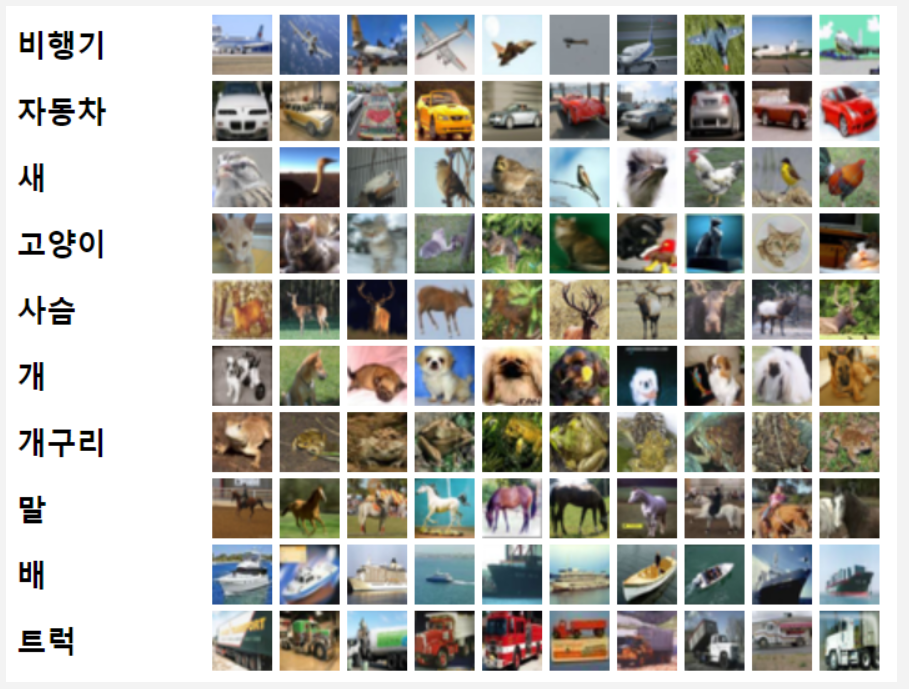

In [ ]:
imgs = torch.stack(imgs,dim=0).numpy()

In [ ]:
imgs.shape

In [ ]:
mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()

print(mean_r,mean_g,mean_b)

In [ ]:
std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()

print(std_r,std_g,std_g)

In [ ]:
# fransforms = Compose([
#     Resize(224),
#     RandomCrop((224,224),padding=4),
#     RandomHorizontalFlip(p=0.5),
#     ToTensor(),
#     Normalize(mean=(0.4914,0.4822,0.4465) , std = (0.247,0.243,0.261))
# ])

In [54]:
# train_data = CIFAR10(
#     root='./',
#     train=True,
#     download=True,
#     transform=fransforms
# )

# test_data = CIFAR10(
#     root='./',
#     train=False,
#     download=True,
#     transform=fransforms
# )

# train_loader = DataLoader(train_data,batch_size=32,shuffle=True)
# test_loader = DataLoader(test_data,batch_size=32,shuffle=True)




transforms_train = transforms.Compose([
    Resize(224),
    # RandomCrop((224,224),padding=4),
    # RandomHorizontalFlip(p=0.5),
    ToTensor(),
    Normalize(mean=(0.4914,0.4822,0.4465) , std = (0.247,0.243,0.261))
])

transforms_test = transforms.Compose([
    Resize(224),
    # RandomCrop((224,224),padding=4),
    # RandomHorizontalFlip(p=0.5),
    ToTensor(),
    Normalize(mean=(0.4914,0.4822,0.4465) , std = (0.247,0.243,0.261))
])

data_dir = './custom_dataset'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)




lr = 0.001
optim = Adam(model.parameters(),lr=lr)

for epoch in range(1):
    iterator = tqdm.tqdm(train_loader)

    for data,label in iterator:
        optim.zero_grad()

        preds = model(data.to(device))
        loss = nn.CrossEntropyLoss()(preds,label.to(device))
        loss.backward()
        optim.step()

        iterator.set_description(f"epoch:{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(),'vgg.pth')

epoch:1 loss:0.7368710041046143: 100%|██████████| 105/105 [14:52<00:00,  8.50s/it]


In [ ]:
epoch:1 loss:0.7368710041046143:
epoch:1 loss:0.7368710041046143:

In [55]:
dict_model = torch.load('vgg.pth',map_location=device)
model.load_state_dict(dict_model)

num_corr = 0

with torch.no_grad():
    for data, label in test_loader:
        output = model(data.to(device))
        preds = output.data.max(1)[1]
        corr = preds.eq(label.to(device).data).sum().item()
        num_corr += corr

    print((num_corr / len(test_datasets)) * 100)

98.25543120473996


In [15]:
98.25543120473996
98.25543120473996

71.98815009874919

In [37]:
for data, label in test_loader:
    print(model(data.to(device)))
    print('======================')
    print(data.to(device))
    break

tensor([[ 0.0668, -0.0789],
        [ 0.0381, -0.0563],
        [ 0.0667, -0.0661],
        [ 0.0431, -0.0424]], grad_fn=<AddmmBackward0>)
tensor([[[[2.0591, 2.0591, 2.0591,  ..., 2.0591, 2.0591, 2.0591],
          [2.0591, 2.0591, 2.0591,  ..., 2.0591, 2.0591, 2.0591],
          [2.0591, 2.0591, 2.0591,  ..., 2.0591, 2.0591, 2.0591],
          ...,
          [2.0591, 2.0591, 2.0591,  ..., 2.0591, 2.0591, 2.0591],
          [2.0591, 2.0591, 2.0591,  ..., 2.0591, 2.0591, 2.0591],
          [2.0591, 2.0591, 2.0591,  ..., 2.0591, 2.0591, 2.0591]],

         [[2.1309, 2.1309, 2.1309,  ..., 2.1309, 2.1309, 2.1309],
          [2.1309, 2.1309, 2.1309,  ..., 2.1309, 2.1309, 2.1309],
          [2.1309, 2.1309, 2.1309,  ..., 2.1309, 2.1309, 2.1309],
          ...,
          [2.1309, 2.1309, 2.1309,  ..., 2.1309, 2.1309, 2.1309],
          [2.1309, 2.1309, 2.1309,  ..., 2.1309, 2.1309, 2.1309],
          [2.1309, 2.1309, 2.1309,  ..., 2.1309, 2.1309, 2.1309]],

         [[2.1207, 2.1207, 2.1207, 

In [50]:
for data, label in test_loader:
    output = model(data.to(device))
    preds = output.data.max(1)[1]
    print(output)
    print(preds)
    print(label)
    corr = preds.eq(label.to(device).data).sum().item()
    print(corr)
    break

tensor([[ 0.0689, -0.0693],
        [ 0.0420, -0.0532],
        [ 0.0713, -0.0851],
        [ 0.0543, -0.0669]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
4


In [56]:
len(test_loader)

760

In [48]:
output.data.max(1)

torch.return_types.max(
values=tensor([0.0447, 0.0437, 0.0610, 0.0338]),
indices=tensor([0, 0, 0, 0]))

In [49]:
output.data.max(1)[1]

tensor([0, 0, 0, 0])

In [38]:
cnt = 0
for data, label in test_loader:
    # print(data)
    print(label, label[0])
    cnt = cnt + 1
    if cnt == 100:
        break

tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 1]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([0, 0, 0, 0]) tensor(0)
tensor([

In [31]:
cnt = 0
for data in test_loader:
    # print(data)
    print(data['label'])
    cnt = cnt + 1
    if cnt == 100:
        break

TypeError: list indices must be integers or slices, not str